# Imports

In [2]:
import os
import cv2 as cv
import numpy as np
import glob
import random
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Functions

In [3]:
def get_file_names(path, platform='win'):
  if platform == 'win':
    return np.array([glob.glob(r'{}\{}\*.jpg'.format(path, i)) for i in range(5)]).flatten()
  elif platform == 'colab':
    return np.array([glob.glob('{}/{}/*.jpg'.format(path, i)) for i in range(5)]).flatten()

def img_resize(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    return cv.resize(img, (width, height), interpolation=cv.INTER_AREA)

def make_hog(dataset, ret='fd'):
    hog_fd = []
    hog_images = []
    for image in dataset:
      fd, hog_img = hog(image, orientations=8, pixels_per_cell=(16, 16), 
              cells_per_block=(1, 1), visualize=True)
      hog_fd.append(fd)
      hog_images.append(hog_img)
    if ret == 'fd':
      return hog_fd
    elif ret == 'img':
      return hog_images

def knn_classification(X_train, y_train, X_test, y_test, neighbors=1, metric='euclidean'):
    clf = KNeighborsClassifier(n_neighbors=neighbors, metric=metric, algorithm='auto')
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(predictions, y_test) * 100
    cm = confusion_matrix(y_test, predictions)
    return (acc, cm)

def rf_classification(X_train, y_train, X_test, y_test, max_depth=1, random_state=0):
    clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(predictions, y_test) * 100
    cm = confusion_matrix(y_test, predictions)
    return (acc, cm)

def flat_dataset(dataset):
    """Transforma fiecare imagine din setul de date intr-un vector de dimensiune
    w x h x 3, unde w este lungimea imaginii, w este latimea (in pixeli), iar 3
    provine de la faptul ca imaginea este reprezentata in format RGB. Doar in
    acest caz, fiecare imagine are dimensiunea 256x256 px, pe 3 canale, astfel ca
    rezultatul va fi un vector cu 196 de mii de elemente.
    Args:
        param1 (list): Setul de date ce se doreste a fi transformat 
    Returns:
        list: Setul de date transformat
    """
    new_dataset = []
    for element in dataset:
        new_dataset.append(np.array(element).flatten())
    return new_dataset
    
def make_heat_map_plt(params):
    fig = plt.figure(figsize=(15,5))
    plt.style.use('seaborn')
    for index, (cm, title, accuracy) in enumerate(params):
        plt.subplot(1, 2, index+1)
        sn.heatmap(cm, annot=True)
        plt.title('Confusion Matrix - {}\nAccuracy: {:.2f}%'.format(title, accuracy), fontsize=16)
        plt.xlabel('Predicted')
        plt.ylabel('True')

def print_images(images, n_row, n_col, cmap='viridis', figsize=(12, 12)):
    """Creaza un grid de imagini pentru a facilita vizualizarea imaginilor
    Args:
        param1 (list): Lista imaginilor ce se doresc a fi vizualizate
        param2 (int): Numarul de linii al gridului
        param3 (int): Numarul de coloane al gridului
    Returns:
        None
    """
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
    plt.show()

# Dataset Preprocessing

## Define Labels

In [4]:
labels = [index for index in range(5) for _ in range(10)]
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


## Get Dataset

In [5]:
path = '/hand_gesture_dataset'
files = get_file_names(path, platform='colab')

In [6]:
dataset = [cv.cvtColor(cv.imread(img), cv.COLOR_BGR2RGB) for img in files]
print(np.shape(dataset))

(50, 2160, 2160, 3)


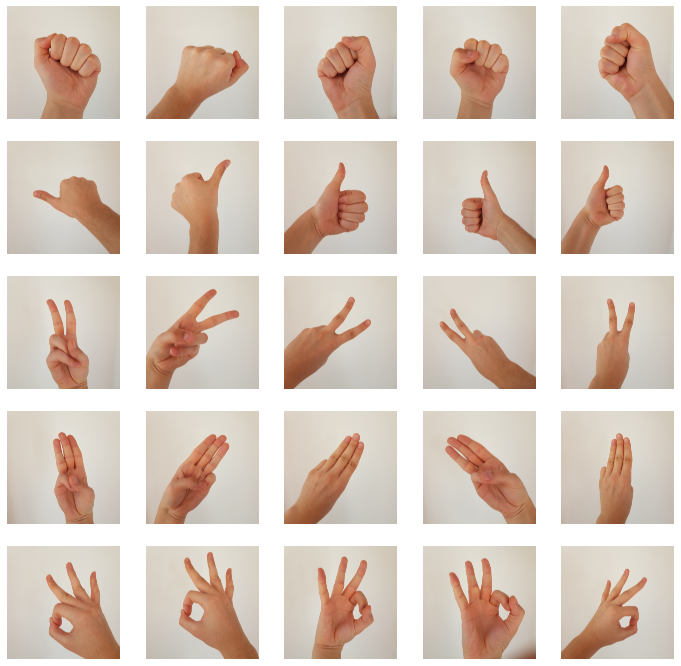

In [7]:
print_images(dataset[::2], 5, 5, figsize=(15,15))

## Gray Dataset

In [8]:
dataset_gray = [cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img in dataset]
print(np.shape(dataset_gray))

(50, 2160, 2160)


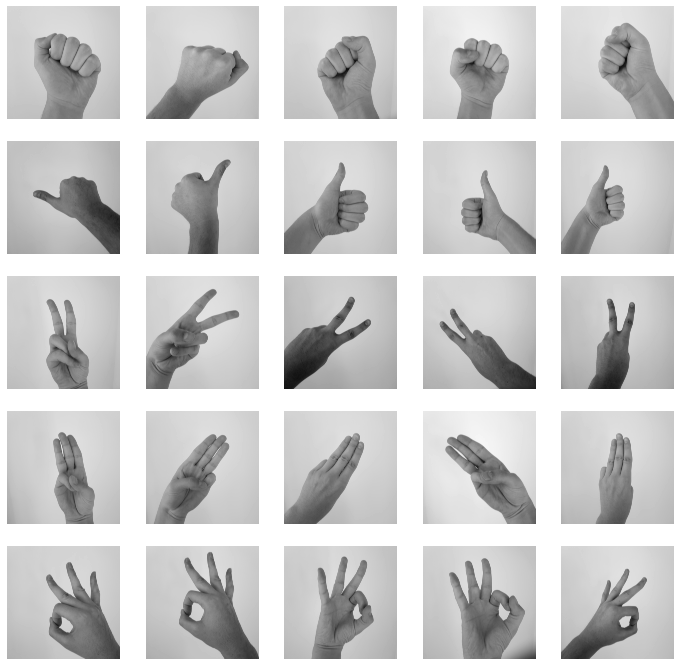

In [9]:
print_images(dataset_gray[::2], 5, 5, cmap='gray')

## Resized Dataset

In [10]:
dataset_res = [img_resize(img, 5) for img in dataset]
print(np.shape(dataset_res))

(50, 108, 108, 3)


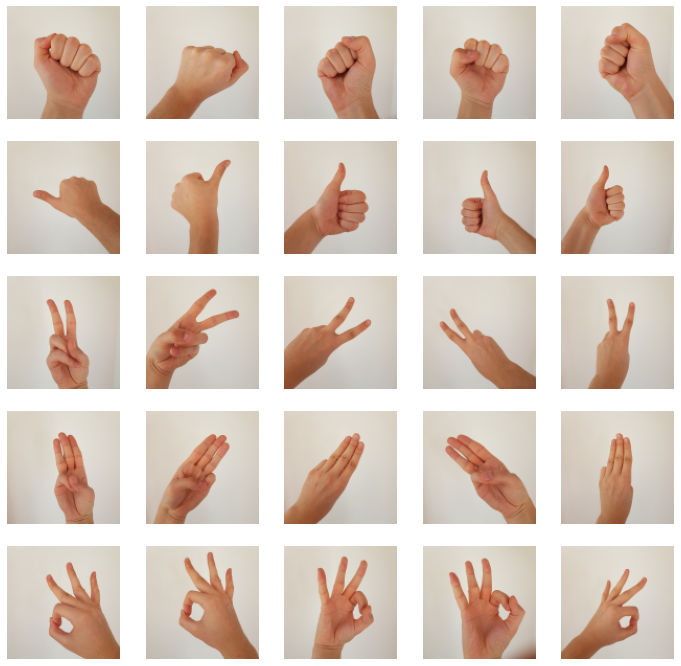

In [11]:
print_images(dataset_res[::2], 5, 5)

## Resized Gray Dataset

In [12]:
dataset_gray_res = [cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img in dataset_res]
print(np.shape(dataset_gray_res))

(50, 108, 108)


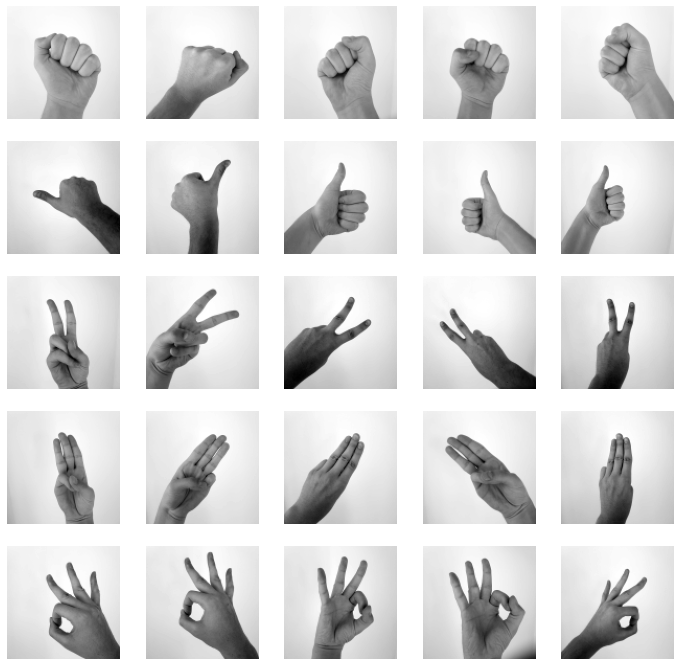

In [13]:
print_images(dataset_gray_res[::2], 5, 5, cmap='gray')

# Histogram of Oriented Gradients

In [14]:
dataset_hog = make_hog(dataset_gray_res, ret='img')
print(np.shape(dataset_hog))

(50, 108, 108)


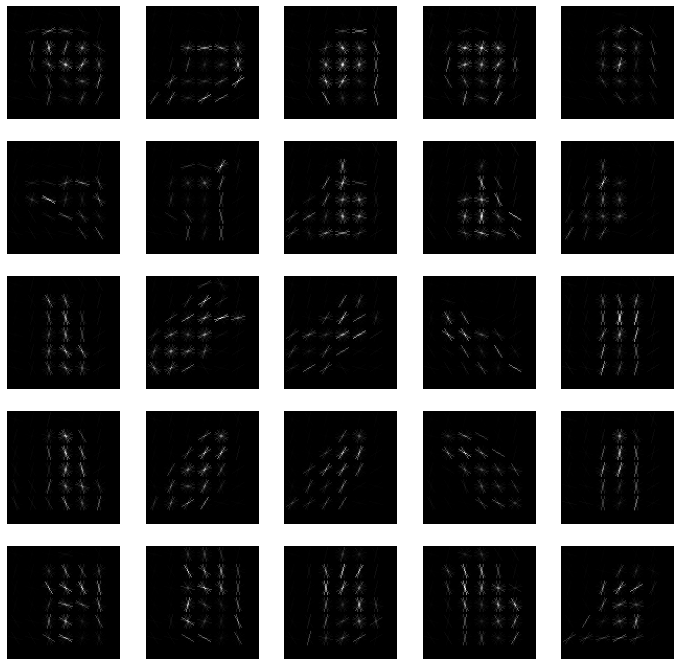

In [15]:
print_images(dataset_hog[::2], 5, 5, cmap='gray')

# Spit Dataset

In [39]:
X_train, X_test, y_train, y_test = train_test_split(dataset_gray_res, labels, test_size=0.2, random_state=40, stratify=labels)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(40, 108, 108)
(10, 108, 108)
(40,)
(10,)


In [40]:
print(labels)
print(y_train)
print(y_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[3, 3, 3, 4, 4, 2, 2, 3, 1, 2, 4, 4, 0, 1, 1, 3, 1, 4, 4, 0, 2, 0, 0, 2, 1, 2, 1, 3, 1, 0, 1, 3, 0, 0, 2, 0, 2, 3, 4, 4]
[2, 3, 4, 2, 0, 0, 4, 1, 3, 1]


# Classification

## Original Dataset

In [41]:
X_train_flatten = flat_dataset(X_train)
X_test_flatten = flat_dataset(X_test)
print(np.shape(X_train_flatten))
print(np.shape(X_test_flatten))

(40, 11664)
(10, 11664)


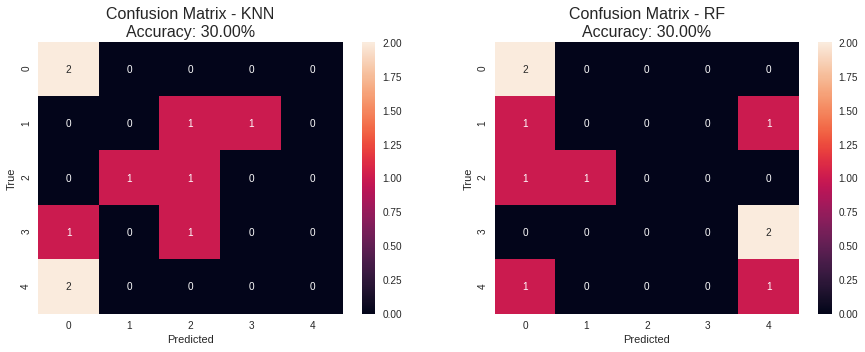

In [42]:
acc_knn, cm_knn = knn_classification(X_train_flatten, y_train, X_test_flatten, y_test)
acc_rf, cm_rf = rf_classification(X_train_flatten, y_train, X_test_flatten, y_test, random_state=0)

params = zip(
    [cm_knn, cm_rf],
    ['KNN', 'RF'],
    [acc_knn, acc_rf])
make_heat_map_plt(params)

## HoG Applied on Dataset

In [43]:
X_train_hog = make_hog(X_train)
X_test_hog = make_hog(X_test)
print(np.shape(X_train_hog))
print(np.shape(X_test_hog))

(40, 288)
(10, 288)


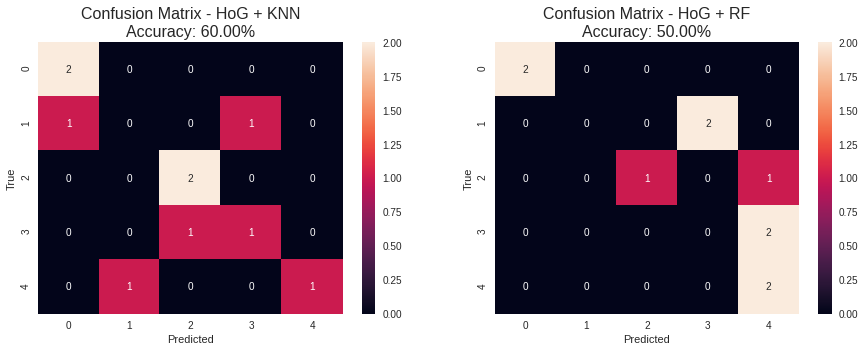

In [44]:
acc_hog_knn, cm_hog_knn = knn_classification(X_train_hog, y_train, X_test_hog, y_test)
acc_hog_rf, cm_hog_rf = rf_classification(X_train_hog, y_train, X_test_hog, y_test)

hog_params = zip(
    [cm_hog_knn, cm_hog_rf],
    ['HoG + KNN', 'HoG + RF'],
    [acc_hog_knn, acc_hog_rf])
make_heat_map_plt(hog_params)

## Grid Search

### Parameters

In [45]:
scaling = [
    ('No scaling', X_train_hog, X_test_hog),
    ('Scale', preprocessing.scale(X_train_hog), preprocessing.scale(X_test_hog)),
    ('Normalize', normalize(X_train_hog, norm='l2', axis=0, copy=True, return_norm=False), 
                  normalize(X_test_hog, norm='l2', axis=0, copy=True, return_norm=False)),
    ('Min Max Scaler', MinMaxScaler().fit_transform(X_train_hog), MinMaxScaler().fit_transform(X_test_hog)),
    ('Max Abs Scaler', MaxAbsScaler().fit_transform(X_train_hog), MaxAbsScaler().fit_transform(X_test_hog))
]

knn_neighbors = [i for i in range(1, 5)]
knn_metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
rf_depth = [i for i in range(1, 8)]

### KNN

In [46]:
grid_search_knn = []
for name, train, test in scaling:
  for neighbor in knn_neighbors:
    for metric in knn_metrics:
      knn = KNeighborsClassifier(n_neighbors=neighbor, metric=metric, algorithm='auto')
      knn.fit(train, y_train)
      predictions = knn.predict(test)
      acc = accuracy_score(predictions, y_test) * 100
      grid_search_knn.append([name, neighbor, metric, acc])
knn_df = pd.DataFrame(grid_search_knn)
knn_df.columns = ['Scaler', 'Neighbors', 'Metric', 'Accuracy']

            Scaler  Neighbors     Metric  Accuracy
32       Normalize          1  euclidean      80.0
35       Normalize          1  minkowski      80.0
48  Min Max Scaler          1  euclidean      80.0
49  Min Max Scaler          1  manhattan      80.0
51  Min Max Scaler          1  minkowski      80.0


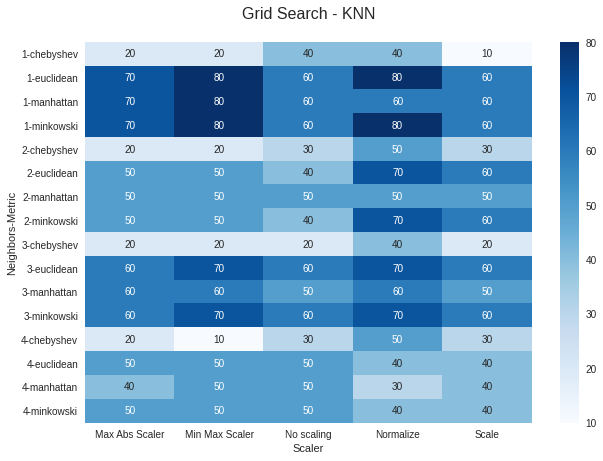

In [47]:
print(knn_df[knn_df.Accuracy == knn_df.Accuracy.max()])
heatmap1_data = pd.pivot_table(knn_df, values='Accuracy', 
                     index=['Neighbors', 'Metric'], 
                     columns=['Scaler'])

plt.figure(figsize=(10,7))
sn.heatmap(heatmap1_data, annot=True, cmap="Blues")
plt.title('Grid Search - KNN\n', fontsize=16)
plt.show()

### Random Forest

In [48]:
grid_search_rf = []
for name, train, test in scaling:
  for depth in rf_depth:
    rf = RandomForestClassifier(max_depth=depth, random_state=40)
    rf.fit(train, y_train)
    predictions = rf.predict(test)
    acc = accuracy_score(predictions, y_test) * 100
    grid_search_rf.append([name, depth, acc])
rf_df = pd.DataFrame(grid_search_rf)
rf_df.columns = ['Scaler', 'Depth', 'Accuracy']

            Scaler  Depth  Accuracy
25  Min Max Scaler      5      80.0
26  Min Max Scaler      6      80.0
27  Min Max Scaler      7      80.0


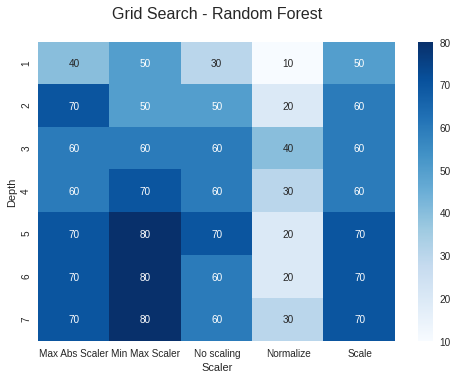

In [49]:
print(rf_df[rf_df.Accuracy == rf_df.Accuracy.max()])
heatmap1_data = pd.pivot_table(rf_df, values='Accuracy', 
                     index=['Depth'], 
                     columns='Scaler')

plt.figure()
sn.heatmap(heatmap1_data, annot=True, cmap="Blues")
plt.title('Grid Search - Random Forest\n', fontsize=16)
plt.show()

# Results

Descriptor length: 288


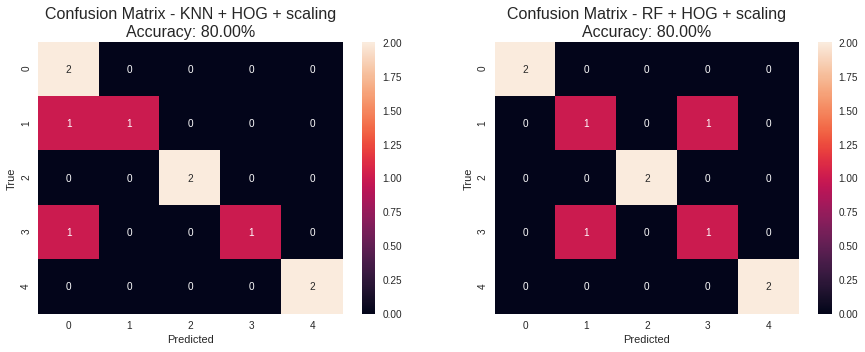

In [50]:
acc_gs_knn, cm_gs_knn = knn_classification(scaling[3][1], y_train, scaling[3][2], y_test)
acc_gs_rf, cm_gs_rf = rf_classification(scaling[3][1], y_train, scaling[3][2], y_test, 5, random_state=40)

print('Descriptor length: {}'.format(np.shape(scaling[2][1])[1]))

params = zip(
    [cm_gs_knn, cm_gs_rf],
    ['KNN + HOG + scaling', 'RF + HOG + scaling'],
    [acc_gs_knn, acc_gs_rf])
make_heat_map_plt(params)